# MCMC & why 3d matters
This example (although quite artificial) shows that viewing a posterior (ok, I have flat priors) in 3d can be quite useful. While the 2d projection may look quite 'bad', the 3d volume rendering shows that much of the volume is empty, and the posterior is much better defined than it seems in 2d.

In [1]:
!pip install emcee corner

In [5]:
!pip show matplotlib

Name: matplotlib
Version: 3.1.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/maartenbreddels/miniconda3/envs/dev/lib/python3.7/site-packages
Requires: python-dateutil, cycler, pyparsing, numpy, kiwisolver
Required-by: seaborn, scikit-image, mpl-scatter-density, ipympl, glue-vispy-viewers, corner, catboost, vaex-viz, vaex-ui, vaex-arrow, glue-core


In [2]:
import pylab
import scipy.optimize as op
import emcee
import numpy as np
%matplotlib inline

In [3]:
# our 'blackbox' 3 parameter model which is highly degenerate
def f_model(x, a, b, c):
    return x * np.sqrt(a**2 +b**2 + c**2) + a*x**2 + b*x**3

Text(0, 0.5, '$y$')

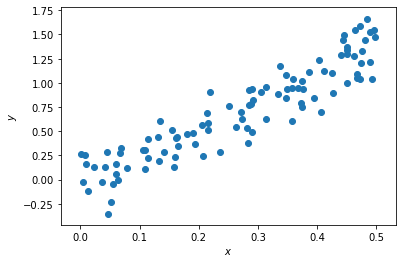

In [4]:
N = 100
a_true, b_true, c_true = -1., 2., 1.5

# our input and output
x = np.random.rand(N)*0.5#+0.5
y = f_model(x, a_true, b_true, c_true)

# + some (known) gaussian noise
error = 0.2
y += np.random.normal(0, error, N)

# and plot our data
pylab.scatter(x, y);
pylab.xlabel("$x$")
pylab.ylabel("$y$")

In [ ]:
# our likelihood
def lnlike(theta, x, y, error):
    a, b, c = theta
    model =  f_model(x, a, b, c)
    chisq = 0.5*(np.sum((y-model)**2/error**2))
    return -chisq
result = op.minimize(lambda *args: -lnlike(*args), [a_true, b_true, c_true], args=(x, y, error))
# find the max likelihood
a_ml, b_ml, c_ml = result["x"]
print("estimates", a_ml, b_ml, c_ml)
print("true values", a_true, b_true, c_true)
result["message"]

In [ ]:
# do the mcmc walk
ndim, nwalkers = 3, 100
pos = [result["x"] + np.random.randn(ndim)*0.1 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, error))
sampler.run_mcmc(pos, 1500);
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Posterior in 2d

In [ ]:
# plot the 2d pdfs
import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$"],
                      truths=[a_true, b_true, c_true])

## Posterior in 3d

In [ ]:
import vaex
import scipy.ndimage
import ipyvolume

In [ ]:
ds = vaex.from_arrays(a=samples[...,0].copy(), b=samples[...,1].copy(), c=samples[...,2].copy())
# get 2d histogram
v = ds.count(binby=["a", "b", "c"], shape=64)
# smooth it for visual pleasure
v = scipy.ndimage.gaussian_filter(v, 2)

In [ ]:
ipyvolume.quickvolshow(v, lighting=True)

Note that actually a large part of the volume is empty.

[screenshot](screenshot/mcmc.png)